<a href="https://colab.research.google.com/github/motokikando/bayes_modeling/blob/master/bayes_confidence_interval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Googleドライブをマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#必要なモジュールのインポート
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pystan 
from scipy.stats import mstats
%matplotlib inline

In [7]:
#スタイルの指定
plt.style.use("ggplot")

In [8]:
file_path = '/content/drive/My Drive/ベイズ統計学/pystan_data/real_estate1.xlsx'
df = pd.read_excel(file_path)

In [9]:
df.head()

,id,space,room,value
0,1,50,2LDK,3050
1,2,70,2LDK,4690
2,3,70,2SLDK,4830
3,4,70,3LDK,5040
4,5,90,3LDK,6570


In [31]:
stan_model = """
data {
  int N;
  real X[N];
  real Y[N];
  int N_s;
  real X_s[N_s];
}

parameters {
  real a;
  real b;
  real<lower=0> sigma;
}

model {
  for (n in 1:N){
    Y[n] ~ normal(a * X[n] + b, sigma);
  }
}

generated quantities {
  real Y_s[N_s];
  for (n in 1:N_s){
    Y_s[n] = normal_rng(a * X_s[n] + b, sigma);
  }
}

"""

In [32]:
sm = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_81acff9de421dcd46dd949b5b0a70352 NOW.


In [33]:
#stanのデータを格納
#予測の区間40~90で1刻み
X_s = np.arange(40, 90, 1)
N_s = X_s.shape[0] #X_sの要素数をとってタプルの配列の0番目を取得
# print(N_s)
stan_data = {"N":df.shape[0], "X":df["space"], "Y":df["value"], "N_s":N_s, "X_s":X_s}


In [34]:
fit = sm.sampling(data=stan_data , iter=2000, warmup=500, chains=3, seed=123)

In [37]:
#データの抽出
fit.extract("b")


OrderedDict([('b', array([ -722.16063717,  -319.67597395,  -380.21570313, ...,
                     -2116.40955681, -1040.88136431,  -105.52896629]))])

In [44]:
ms_a = fit.extract("a")["a"]
ms_b = fit.extract("b")["b"]

In [47]:
ms_a
ms_b

array([ -722.16063717,  -319.67597395,  -380.21570313, ...,
       -2116.40955681, -1040.88136431,  -105.52896629])

(array([   5.,   17.,  148.,  604., 1251., 1382.,  751.,  277.,   57.,
           8.]),
 array([-4213.44882868, -3534.17298557, -2854.89714247, -2175.62129937,
        -1496.34545626,  -817.06961316,  -137.79377005,   541.48207305,
         1220.75791615,  1900.03375926,  2579.30960236]),
 <a list of 10 Patch objects>)

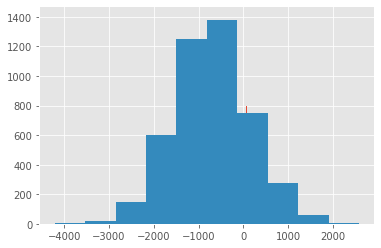

In [45]:
plt.hist(ms_a)

(array([   5.,   17.,  148.,  604., 1251., 1382.,  751.,  277.,   57.,
           8.]),
 array([-4213.44882868, -3534.17298557, -2854.89714247, -2175.62129937,
        -1496.34545626,  -817.06961316,  -137.79377005,   541.48207305,
         1220.75791615,  1900.03375926,  2579.30960236]),
 <a list of 10 Patch objects>)

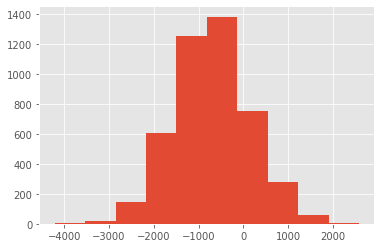

In [46]:
plt.hist(ms_b)

In [48]:
df_b = pd.DataFrame([])
for i in range(40, 90, 1):
  df_b[i] = ms_a*i+ms_b
  

In [49]:
df_b

,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89
0,2343.929351,2420.581601,2497.233850,2573.886100,2650.538350,2727.190600,2803.842849,2880.495099,2957.147349,3033.799598,3110.451848,3187.104098,3263.756347,3340.408597,3417.060847,3493.713097,3570.365346,3647.017596,3723.669846,3800.322095,3876.974345,3953.626595,4030.278844,4106.931094,4183.583344,4260.235594,4336.887843,4413.540093,4490.192343,4566.844592,4643.496842,4720.149092,4796.801342,4873.453591,4950.105841,5026.758091,5103.410340,5180.062590,5256.714840,5333.367089,5410.019339,5486.671589,5563.323839,5639.976088,5716.628338,5793.280588,5869.932837,5946.585087,6023.237337,6099.889586
1,2681.357295,2756.383127,2831.408959,2906.434791,2981.460622,3056.486454,3131.512286,3206.538117,3281.563949,3356.589781,3431.615613,3506.641444,3581.667276,3656.693108,3731.718940,3806.744771,3881.770603,3956.796435,4031.822267,4106.848098,4181.873930,4256.899762,4331.925593,4406.951425,4481.977257,4557.003089,4632.028920,4707.054752,4782.080584,4857.106416,4932.132247,5007.158079,5082.183911,5157.209743,5232.235574,5307.261406,5382.287238,5457.313069,5532.338901,5607.364733,5682.390565,5757.416396,5832.442228,5907.468060,5982.493892,6057.519723,6132.545555,6207.571387,6282.597219,6357.623050
2,2556.329185,2629.742808,2703.156430,2776.570052,2849.983674,2923.397296,2996.810919,3070.224541,3143.638163,3217.051785,3290.465407,3363.879030,3437.292652,3510.706274,3584.119896,3657.533518,3730.947141,3804.360763,3877.774385,3951.188007,4024.601630,4098.015252,4171.428874,4244.842496,4318.256118,4391.669741,4465.083363,4538.496985,4611.910607,4685.324229,4758.737852,4832.151474,4905.565096,4978.978718,5052.392341,5125.805963,5199.219585,5272.633207,5346.046829,5419.460452,5492.874074,5566.287696,5639.701318,5713.114940,5786.528563,5859.942185,5933.355807,6006.769429,6080.183051,6153.596674
3,2925.553417,2991.500110,3057.446802,3123.393495,3189.340188,3255.286880,3321.233573,3387.180266,3453.126958,3519.073651,3585.020344,3650.967036,3716.913729,3782.860422,3848.807114,3914.753807,3980.700500,4046.647192,4112.593885,4178.540578,4244.487271,4310.433963,4376.380656,4442.327349,4508.274041,4574.220734,4640.167427,4706.114119,4772.060812,4838.007505,4903.954197,4969.900890,5035.847583,5101.794275,5167.740968,5233.687661,5299.634353,5365.581046,5431.527739,5497.474431,5563.421124,5629.367817,5695.314509,5761.261202,5827.207895,5893.154587,5959.101280,6025.047973,6090.994665,6156.941358
4,2921.653507,2984.732715,3047.811922,3110.891130,3173.970337,3237.049545,3300.128752,3363.207960,3426.287167,3489.366375,3552.445582,3615.524790,3678.603998,3741.683205,3804.762413,3867.841620,3930.920828,3994.000035,4057.079243,4120.158450,4183.237658,4246.316865,4309.396073,4372.475280,4435.554488,4498.633696,4561.712903,4624.792111,4687.871318,4750.950526,4814.029733,4877.108941,4940.188148,5003.267356,5066.346563,5129.425771,5192.504978,5255.584186,5318.663394,5381.742601,5444.821809,5507.901016,5570.980224,5634.059431,5697.138639,5760.217846,5823.297054,5886.376261,5949.455469,6012.534676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,2674.630410,2745.851499,2817.072589,2888.293678,2959.514767,3030.735857,3101.956946,3173.178036,3244.399125,3315.620214,3386.841304,3458.062393,3529.283483,3600.504572,3671.725661,3742.946751,3814.167840,3885.388930,3956.610019,4027.831108,4099.052198,4170.273287,4241.494377,4312.715466,4383.936555,4455.157645,4526.378734,4597.599824,4668.820913,4740.042002,4811.263092,4882.484181,4953.705271,5024.926360,5096.147449,5167.368539,5238.589628,5309.810718,5381.031807,5452.252896,5523.473986,5594.695075,5665.916165,5737.137254,5808.358343,5879.579433,5950.800522,6022.021612,6093.242701,6164.463790
4496,2265.685352,2351.798480,2

In [50]:
#下限値と上限値
low_y50, high_y50 = mstats.mquantiles(df_b, [0.25, 0.75], axis=0)
low_y95, high_y95 = mstats.mquantiles(df_b, [0.025, 0.975], axis=0) 

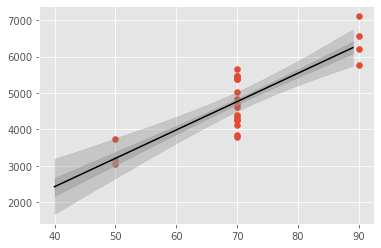

In [53]:
plt.scatter(df["space"], df["value"])
plt.fill_between(X_s, low_y50, high_y50, alpha=0.6, color="darkgray")
plt.fill_between(X_s, low_y95, high_y95, alpha=0.3, color="gray")
a = 77.96
b = -691.7
x = np.arange(40, 90, 1)
y = a * X_s + b
plt.plot(X_s, y, color="black")

In [54]:
#ベイズ予測区間
Y_p = fit.extract("Y_s")["Y_s"]

In [55]:
low_y, high_y = mstats.mquantiles(Y_p, [0.025, 0.975], axis=0)

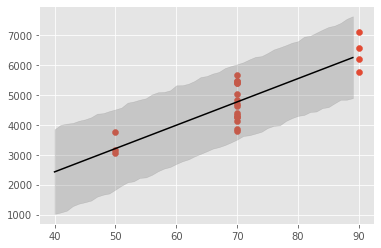

In [56]:
plt.scatter(df["space"], df["value"])
plt.fill_between(X_s, low_y, high_y, alpha=0.3, color="gray")

a = 77.96
b = -691.7
x = np.arange(40, 90, 1)
y = a * X_s + b
plt.plot(X_s, y, color="black")